In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [185]:
pre_len = 12
model_type = "dcrnn"
type_predict = "test"
num_nodes = 304
# list_model_type = ["ground_truth", "HA", "lstm", "gru"]
list_model_type = ["ground_truth", "tgcn", "a3tgcn", "stgcn",  "dcrnn"]

data_path = f"../result_predict/seoul/{pre_len}/{model_type}/{type_predict}.npy"

In [186]:
def read_data(data_path: str, n_dim = 3):
    predict_data_3d = np.load(data_path)
    if n_dim == 3:
        return predict_data_3d
    if n_dim == 2:
        return np.reshape(predict_data_3d, [-1, num_nodes])
    if n_dim == 1:
        return predict_data_3d.flatten()

In [187]:
model_predicts_3d = {}
model_predicts_2d = {}
model_predicts_1d = {}

for model_type in list_model_type:
    data_path = f"../result_predict/seoul/{pre_len}/{model_type}/{type_predict}.npy"
    model_predicts_3d[model_type] = read_data(data_path=data_path, n_dim=3)
    model_predicts_2d[model_type] = read_data(data_path=data_path, n_dim=2)
    model_predicts_1d[model_type] = read_data(data_path=data_path, n_dim=1)

In [188]:
model_predicts_3d["ground_truth"].shape

(1705, 304, 12)

In [189]:
model_predicts_3d["HA"].shape

KeyError: 'HA'

### Графики по датчику

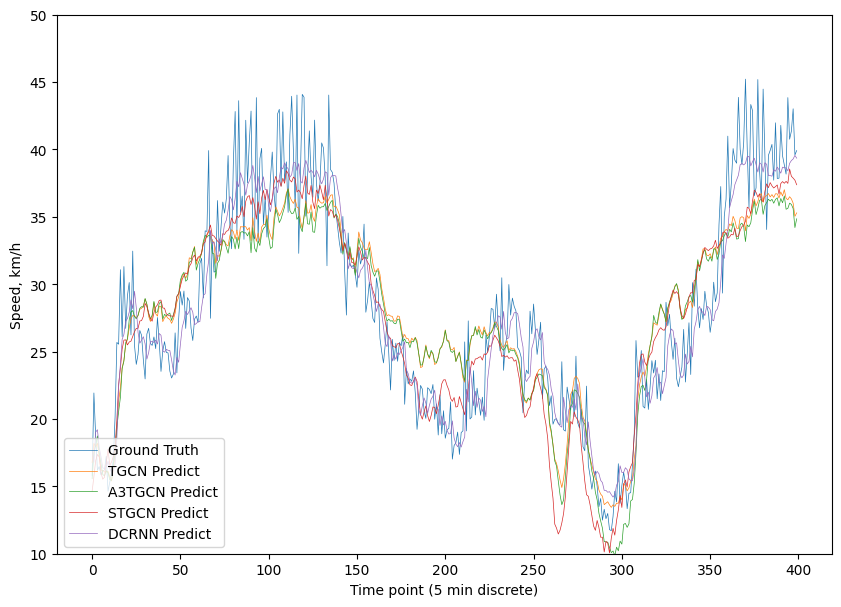

In [190]:
node_idx = 50 # max 303
start_timestamp = 500
end_timestamp = 900
pre_idx = 0

plt.figure(figsize=(10,7))
for model_type in list_model_type:
    if model_type == "ground_truth":
        label = "Ground Truth"
    else:
        label = f"{model_type.upper()} Predict"
    plt.plot(
        model_predicts_3d[model_type][start_timestamp:end_timestamp, node_idx, pre_idx],
        linewidth=0.5,
        label=label,
    )

# plt.title(f"Seoul data, horizon {pre_len}")
# plt.figtext(
#     x=0.75,
#     y=0.15,
#     s=f"""sensor_num={node_idx}, \nstart_timestamp={start_timestamp}, \nend_timestamp={end_timestamp}""",
#     color="grey",
#     ha="left",
#     fontsize=7,
#     bbox={"facecolor": "orange", "alpha":0.5, "pad": 5}
# )
plt.ylim([10, 50])
plt.xlabel("Time point (5 min discrete)")
plt.ylabel("Speed, km/h")
plt.legend(loc="lower left")
plt.show()

### Графики по временной метке

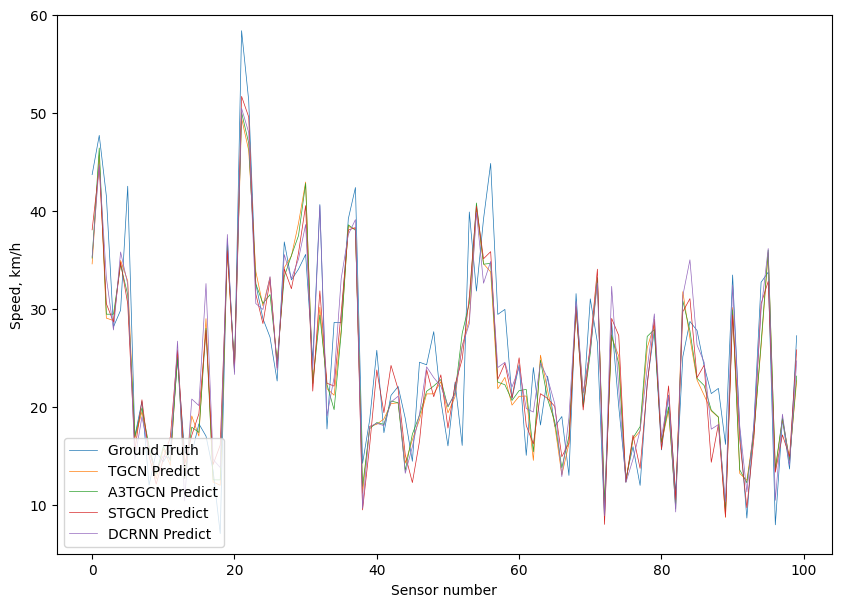

In [191]:
timestamp_idx = 500
pre_idx = 11
start_sensor_idx = 0
end_sensor_idx = 100 # max 303

plt.figure(figsize=(10,7))
for model_type in list_model_type:
    if model_type == "ground_truth":
        label = "Ground Truth"
    else:
        label = f"{model_type.upper()} Predict"
    plt.plot(
        model_predicts_3d[model_type][timestamp_idx, start_sensor_idx:end_sensor_idx, pre_idx],
        linewidth=0.5,
        label=label,
    )

# plt.title(f"Seoul data, horizon {pre_len}")
# plt.figtext(
#     x=0.75,
#     y=0.15,
#     s=f"""timestamp_num={timestamp_idx}, \nstart_sensor_idx={start_sensor_idx+1}, \nend_sensor_idx={end_sensor_idx+1} \npre_len={pre_idx+1}""",
#     color="grey",
#     ha="left",
#     fontsize=7,
#     bbox={"facecolor": "orange", "alpha":0.5, "pad": 5}
# )
plt.ylim([5, 60])
plt.xlabel("Sensor number")
plt.ylabel("Speed, km/h")
plt.legend(loc="lower left")
plt.show()

### Расчет метрик

In [64]:
metrics = {}

In [65]:
def mae(y_true_2d, y_pred_2d):
    return np.round(mean_absolute_error(y_true=y_true_2d, y_pred=y_pred_2d), 2)


def rmse(y_true_2d, y_pred_2d):
    return np.round(np.sqrt(mean_squared_error(y_true=y_true_2d, y_pred=y_pred_2d)), 2)


def r2(y_true_2d, y_pred_2d):
    return np.round(r2_score(y_true=y_true_2d, y_pred=y_pred_2d), 2) 


def smape(y_true_1d, y_pred_1d):
    return np.round(100/len(y_true_1d) * np.sum(np.abs(y_pred_1d - y_true_1d) / (np.abs(y_true_1d) + np.abs(y_pred_1d))), 2)

In [66]:
for model_type in list_model_type:
    if model_type != "ground_truth":
        metrics[model_type] = {}
        metrics[model_type]["mae"] = mae(model_predicts_2d["ground_truth"], model_predicts_2d[model_type])
        metrics[model_type]["rmse"] = rmse(model_predicts_2d["ground_truth"], model_predicts_2d[model_type])
        metrics[model_type]["smape"] = smape(model_predicts_1d["ground_truth"], model_predicts_1d[model_type])
        metrics[model_type]["r2"] = r2(model_predicts_1d["ground_truth"], model_predicts_1d[model_type])

In [67]:
pd.DataFrame(metrics).T

,mae,rmse,smape,r2
HA,3.21,4.65,6.25,0.83
lstm,2.83,4.15,5.53,0.87
gru,2.85,4.17,5.56,0.86
tgcn,3.36,4.68,6.65,0.83
a3tgcn,3.34,4.66,6.60,0.83
stgcn,2.94,4.22,5.74,0.86
dcrnn,3.02,4.40,5.85,0.85
